# Assignment 2


In this assignment we will cover topics from the previous 3 lectures. We will cover the following topics:

1) Training a simple Linear Model

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy.

4) Implement Dropout/Different Optimizer setups.

5) Implementing Pool and Training on CIFAR10?


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify and input $x_n$ of size $n$ into one of $m$ classes. For this goal, you need to create the following parts:

1) ** A weight Matrix $W_{n\times m}$ **, where the Weights are multipled to the input $X_n$ (Vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2) ** The Loss function **: We learnt two Kinds of Loss functions:
  *  The Hinge Loss: This loss measures, for each sample, how many times were the wrong classes scored above correct class score - $\Delta$ ? and by how much? This leads to the formulation:
  
$$
L_i = \sum_{j\neq y_i} \max(0, s_j - s_{y_i} + \Delta)
$$

where $y_i$ is the correct class, and $s_j$ is the score for the $j$-th class (the $j$-th element of $S_m$)
  
  * The softmax Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $i$-th element of the output of $W^T_{n \times m} . X_m$

4) ** Regularization term **: In addition to the loss, you need a Regularization term to lead to a more distributed( in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, and having $L_2$ regularization would imply that your loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2,
$$

making the total loss:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

3) ** An Optimization Procedure **: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:

$$
W_{t+1} = W_{t} + \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, as we will be doing "mini-batch" gradient Descent, instead of finding loss over the whole dataset, we find it only for a small sample of the traning data for each learning step we take. Basically,
$$
W_{t+1} = W_{t} + \alpha \frac{\partial \sum^{b}{L_{x_i}}}{\partial W},
$$
where, $b$ is the batch size.

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset. Guidelines:
* Use a loss of your choice.
* Keep a validation split of the trainingset for finding the right value of $\lambda$ for the regularization, and to check for over fitting.
* Finally,evaluate the classification performance on the testset.


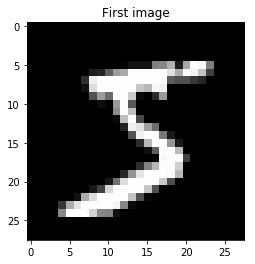

First label :5

Training data size :(60000, 784)
Testing data size : (10000, 784)


In [619]:
## Load The Mnist data:
# Download data from http://yann.lecun.com/exdb/mnist/
# load the data.
import numpy as np
import struct
import os
from matplotlib import pyplot as plt
from matplotlib import cm

def read_idx(fname_img,fname_label):
    IMG_HEADSIZE=16
    LABEL_HEADSIZE=8
    img=open(fname_img,"rb")
    label=open(fname_label,"rb")
    img_magic,img_num,img_rows,img_columns=struct.unpack(">IIII",img.read(IMG_HEADSIZE))
    img.seek(IMG_HEADSIZE,os.SEEK_SET)
    img_data=np.fromfile(img,dtype=np.uint8).reshape(img_num,img_rows*img_columns)
    label_magic,label_num=struct.unpack(">II",label.read(LABEL_HEADSIZE))
    label.seek(LABEL_HEADSIZE,os.SEEK_SET)
    label_data=np.fromfile(label,dtype=np.uint8)
    return img_data,label_data  

[train_img, train_label] =read_idx('MNIST_Data/train-images.idx3-ubyte', 'MNIST_Data/train-labels.idx1-ubyte')
[test_img, test_label] =read_idx('MNIST_Data/t10k-images.idx3-ubyte', 'MNIST_Data/t10k-labels.idx1-ubyte')

# verifying if the data extracted properly
image = train_img[0,:].reshape(28,28)
plt.imshow(image, cmap = plt.get_cmap('gray'))
plt.title('First image')
plt.show()
print "First label :"+ str(train_label[0])

print "\nTraining data size :" + str(train_img.shape)
print "Testing data size : " + str(test_img.shape)

In [620]:
# split the data into train, and valid
count_training_data = int(0.80 * len(train_img))

training_data = train_img[0:count_training_data]
training_labels = train_label[0:count_training_data].reshape(count_training_data,1)

validation_data = train_img[count_training_data:len(train_img)]
validation_labels = train_label[count_training_data:len(train_img)].reshape(len(validation_data),1)

# Now a function, which returns a generator random mini-batch of the input data
minibatch_size = 20
np.random.seed(200)

def get_minibatch_function(training_x, training_y):
    
    def get_minibatch(training_x=training_x, training_y=training_y):
        ## Read generator functions if required.
        assert training_x.shape[0] == training_y.shape[0]
        indices = np.arange(training_x.shape[0])
        np.random.shuffle(indices)      
        ## WRITE CODE HERE
        for start_idx in range(0, training_x.shape[0] - minibatch_size + 1, minibatch_size):
            excerpt = indices[start_idx:start_idx + minibatch_size]
            mini_x = training_x[excerpt]
            mini_y = training_y[excerpt] 
            yield mini_x,mini_y
        
    return get_minibatch

minibatch = get_minibatch_function(training_data, training_labels)
print "Each minibatch contains : " + str(minibatch_size) +" samples"
#for iter,(input_x, input_y) in enumerate(z()):    

Each minibatch contains : 20 samples


In [632]:
# Define the class Single Layer Classifier
class single_layer_classifier():
    
    def __init__(self, input_size, output_size, lamda, lr):     
        # Give the instance a weight matrix, initialized randomly.
        self.W = 0.01 * np.random.randn(input_size + 1,output_size)
        self.num_examples = minibatch_size
        self.lamda = lamda
        self.input_x = np.zeros((minibatch_size, input_size + 1))
        self.lr = lr
        
    # Define the forward function
    def forward(self, input_x):    
        # get the scores
        self.input_x = np.insert(input_x, 0, 1, axis=1)
        scores = np.dot(self.input_x, self.W)
        scores = np.array([score - np.max(score) for score in scores])
        return scores
    
    # Similarly a backward function
    # we define 2 backward functions (as Loss = L1 + L2, grad(Loss) = grad(L1) + grad(L2))
    
    def backward_from_loss(self, input_x, grad_from_loss):
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the loss w.r.t. the respective element of weight.
        grad_matrix = np.dot(input_x.T, grad_from_loss)
        return grad_matrix
        
    def backward_from_l2(self):
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the regularization_term
        # w.r.t. the respective element of weight.
        
        grad_matrix = self.lamda*self.W 
        return grad_matrix
    
    # BONUS
    
    def grad_checker(self, analytical_grad, numerical_grad):
        
        diff = np.absolute(analytical_grad-numerical_grad)
        denominator = np.maximum(np.absolute(analytical_grad), np.absolute(numerical_grad))
        relative_error = diff/(denominator*1.0)
        threshold = 1e-2 + np.zeros(self.W.shape)
        if (relative_error<=threshold).all():
            return 1
        else:
            return 0
        
    def eval_numerical_gradient(self,input_x,input_y,loss):
        weight_num = self.W    
        grad = np.zeros(self.W.shape)
        h = 0.00001

        # iterate over all indexes in x
        it = np.nditer(weight_num, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:

            # evaluate function at x+h
            ix = it.multi_index
            old_value = weight_num[ix]
            weight_num[ix] = old_value + h # increment by h
            newloss, probs = self.loss_forward(input_y,self.forward(input_x)) # evalute f(x + h)
            weight_num[ix] = old_value # restore to previous value

            # compute the partial derivative
            grad[ix] = (newloss - loss) / h # the slope
            it.iternext() # step to next dimension

        return grad
       
    # Now we need the loss functions,one which calculates the loss, 
    # and one which give the backward gradient
    # Make any one of the suggested losses

    def loss_forward(self, input_y, scores):
        exp_scores = np.exp(scores)
        probs = exp_scores / (np.sum(exp_scores, axis=1, keepdims=True)+1e-4)
        probs += 1e-4
        corect_logprobs = []
        for index in range(len(probs)):
            label = input_y[index]
            corect_logprobs.append(-np.log(probs[index, label]))
        corect_logprobs = np.array(corect_logprobs)
        data_loss = np.sum(corect_logprobs)/self.num_examples
        reg_loss = np.sum(self.W*self.W)
        loss = data_loss + 0.5*self.lamda*reg_loss
        return loss, probs

    def loss_backward(self, probs, input_y):
        # This part deals with the gradient from the loss to the weight matrix.
        # for example, in case of softmax loss(-log(qc)), this part gives grad(loss) w.r.t. qc
        dscores = probs
        for index in range(len(dscores)):
            label = input_y[index]
            dscores[index,label] -= 1        
        dscores /= self.num_examples
        grad_from_loss = dscores
        return grad_from_loss

In [633]:
# Finally the trainer:

# let it be for t iterations:

# make an instance of single_layer_classifier,
# get the mini-batch yielder.

def train(layer_obj, epoch):
    for k in range(epoch):
        lossvalues = []
        for iter,(input_x, input_y) in enumerate(minibatch()):

                ## Write code here for each iteration of training.
                scores = obj.forward(input_x)
                loss, probs = obj.loss_forward(input_y, scores)
                lossvalues.append(loss)
                grad_from_loss = obj.loss_backward(probs, input_y)
                grad_matrix_1 = obj.backward_from_loss(obj.input_x, grad_from_loss)
                grad_matrix_2 = obj.backward_from_l2()
                overall_grad_matrix = grad_matrix_1 + grad_matrix_2
            #   numerical_gradient_matrix = obj.eval_numerical_gradient(input_x,input_y,loss)
            #   test = obj.grad_checker(overall_grad_matrix, numerical_gradient_matrix)
            #   print np.max(test)
                obj.lr = obj.lr * ((0.000001 * iter + 1) ** -0.75)
                obj.W += -obj.lr * overall_grad_matrix

        plt.plot(lossvalues)
        plt.ylabel('Loss Values')
        plt.xlabel('Epoch:' + str(k+1))
        plt.show()

In [634]:
# Find the performance on the validation set.
# find the top-1 accuracy on the validation set.
def data_accuracy(validation_data,validation_labels, obj) :
    scores = obj.forward(validation_data)
    predicted =  np.argmax(scores, axis=1).reshape(-1,1)
    accuracy_value = np.sum(predicted == validation_labels)*1.0/len(validation_data)
    return accuracy_value

In [635]:
# now make a trainer function based on the above code, which trains for 't' iteration,
# and returns the performance on the validation

def trainer(iterations, kwargs):
    train(kwargs['layer_obj'], iterations)
    top_1 = data_accuracy(kwargs['validation_data'],kwargs['validation_labels'], kwargs['layer_obj'])   
    return top_1

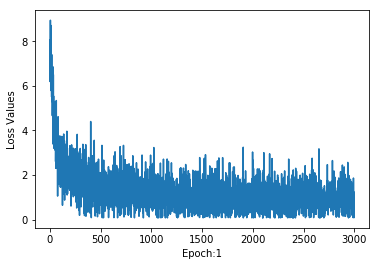

The top 1 Accuracy for lamda=0.2 and t=1 is 0.865833333333


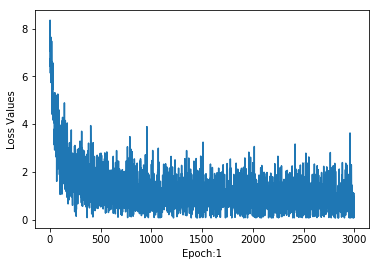

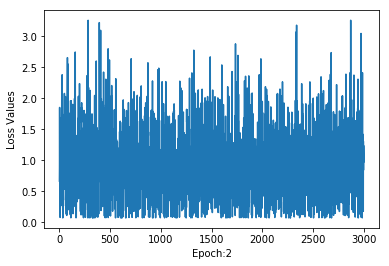

The top 1 Accuracy for lamda=0.2 and t=2 is 0.870666666667


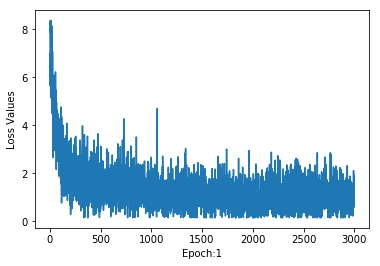

The top 1 Accuracy for lamda=0.4 and t=1 is 0.872083333333


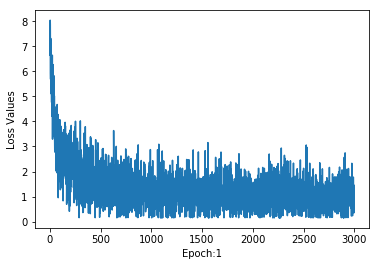

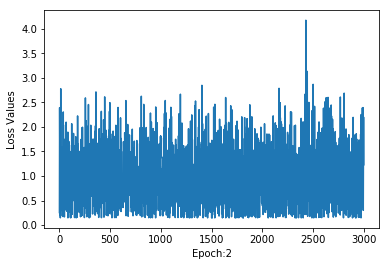

The top 1 Accuracy for lamda=0.4 and t=2 is 0.868


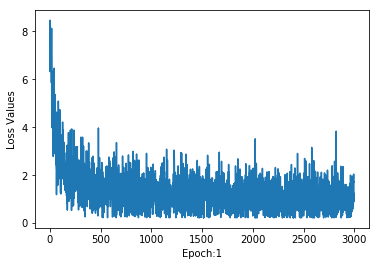

The top 1 Accuracy for lamda=0.6 and t=1 is 0.868833333333


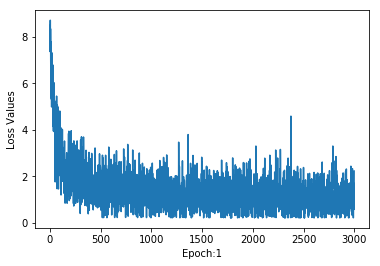

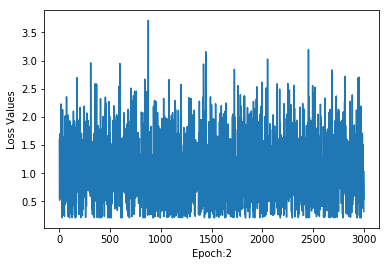

The top 1 Accuracy for lamda=0.6 and t=2 is 0.867083333333


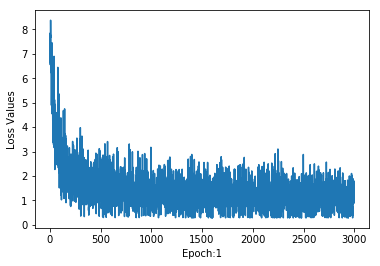

The top 1 Accuracy for lamda=0.8 and t=1 is 0.869583333333


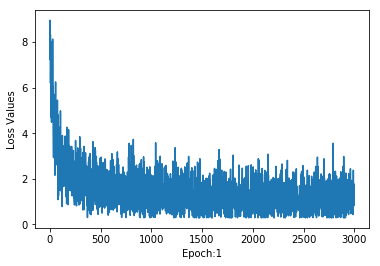

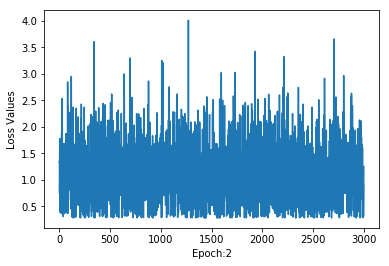

The top 1 Accuracy for lamda=0.8 and t=2 is 0.87075


In [636]:
# Find the optimal lambda and iterations t
lamda_and_t = [[0.2,1],[0.2,2], [0.4,1],[0.4,2],[0.6,1],[0.6,2],[0.8,1],[0.8,2]] #lamda followed by t, combinations
top_1_accuracy = []

for lamda_t_combinations in lamda_and_t:
    obj = single_layer_classifier(training_data.shape[1],10, lamda_t_combinations[0], 0.00001)
    mydic ={}
    mydic['validation_data'] = validation_data
    mydic['validation_labels'] = validation_labels
    mydic['layer_obj'] = obj
    accuracy = trainer(lamda_t_combinations[1], mydic)
    top_1_accuracy.append(accuracy)
    print "The top 1 Accuracy for lamda="+ str(lamda_t_combinations[0])+ " and t="+ str(lamda_t_combinations[1])+" is "+ str(accuracy)  

The optimal values of lamda is: 0.4
The optimal values of iteration t is: 1


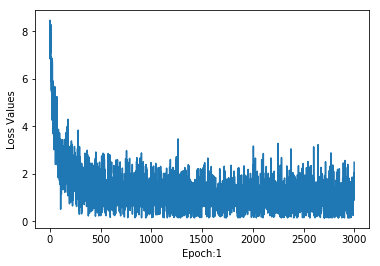

The Accuracy on MNIST test set is 0.8626

The class 0 has accuarcy : 0.941836734694
The class 1 has accuarcy : 0.95154185022
The class 2 has accuarcy : 0.825581395349
The class 3 has accuarcy : 0.845544554455
The class 4 has accuarcy : 0.867617107943
The class 5 has accuarcy : 0.776905829596
The class 6 has accuarcy : 0.897703549061
The class 7 has accuarcy : 0.88326848249
The class 8 has accuarcy : 0.79363449692
The class 9 has accuarcy : 0.823587710605

The best performing class is : class 1
The worst performing class is : class 5


In [638]:
print "The optimal values of lamda is: " + str(lamda_and_t[np.argmax(top_1_accuracy)][0])
print "The optimal values of iteration t is: " + str(lamda_and_t[np.argmax(top_1_accuracy)][1])

# Train on whole dataset with these values,(from scratch)
obj = single_layer_classifier(training_data.shape[1],10, lamda_and_t[np.argmax(top_1_accuracy)][0], 0.00001)
minibatch = get_minibatch_function(train_img, train_label.reshape(len(train_label), 1))
train(obj, lamda_and_t[np.argmax(top_1_accuracy)][1])

# report final performance on mnist test set.
top_1 = data_accuracy(test_img,test_label.reshape(len(test_label), 1),obj) 
print "The Accuracy on MNIST test set is "+ str(top_1)

# Find the best performing class and the worst performing class.
def class_accuracy(classlabel, predicted, test_label):
    total_count_classlabel =  len(np.where( test_label == classlabel)[0])
    index = np.where( test_label == classlabel)[0]
    return np.sum(predicted[index] == test_label[index])*1.0/total_count_classlabel

scores = obj.forward(test_img)
test_label = test_label.reshape(len(test_label), 1)
predicted =  np.argmax(scores, axis=1).reshape(-1,1)
print "\nThe class 0 has accuarcy : " + str(class_accuracy(0, predicted, test_label))
print "The class 1 has accuarcy : " + str(class_accuracy(1, predicted, test_label))
print "The class 2 has accuarcy : " + str(class_accuracy(2, predicted, test_label))
print "The class 3 has accuarcy : " + str(class_accuracy(3, predicted, test_label))
print "The class 4 has accuarcy : " + str(class_accuracy(4, predicted, test_label))
print "The class 5 has accuarcy : " + str(class_accuracy(5, predicted, test_label))
print "The class 6 has accuarcy : " + str(class_accuracy(6, predicted, test_label))
print "The class 7 has accuarcy : " + str(class_accuracy(7, predicted, test_label))
print "The class 8 has accuarcy : " + str(class_accuracy(8, predicted, test_label))
print "The class 9 has accuarcy : " + str(class_accuracy(9, predicted, test_label))

print "\nThe best performing class is : class "+ str(1)
print "The worst performing class is : class "+ str(5)

# Implementing Backprop

Now that you have had some experience with single layer networks, its time to go to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simple put, a way of computing gradients of expressions through recursive application of chain rule. If,
$$
L = f (g (h (\textbf{x})))
$$
then,
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \times \frac{\partial g}{\partial h} \times\frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following functions w.r.t. the input.

1) $$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times \sigma(x))+sin(\pi \times \sigma(y/2))}{z^2}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following values:
  * $(x,y,z)$ =  (1,2,3)
  * $(x,y,z)$ =  (3,2,1)
  * $(x,y,z)$ =  (12,23,31)
  * $(x,y,z)$ =  (32,21,13)

2) $$ f(x,y,z) = -tan(z) + exp(4x^2 + 3x + 10) - x^{y^z} $$
where $\exp$ is the exponential function. Find gradient for the following values:
  * $(x,y,z)$ =  (-0.1 ,2 ,-3)
  * $(x,y,z)$ =  (-3, 0.2,0.5)
  * $(x,y,z)$ =  (1.2, -2.3, 3.1)
  * $(x,y,z)$ =  (3.2, 2.1, -1.3)
      

In [721]:
# To solve this problem, construct the computational graph (will help understanding the problem)(not part of assignment)
# Write each component of the graph as a class, with forward and backward functions.

# for eg:
class sigmoid1():
    def __init__(self):
        self.x = 0
           
    def forward(self, x):
        # save values useful for backpropagation
        self.x =  1.0 / (1 + np.exp(-x))
        return self.x
            
    def backward(self, dz):
        dx = self.x * (1-self.x)
        return dx*dz
        
# CAUTION: Carefully treat the input and output dimension variation. At worst, handle them with if statements.
# Similarly create the classes for various sub-parts/elements of the graph.

class sigmoid2():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x =  1.0 / (1 + np.exp(-x))
        return self.x
    
    def backward(self, dz):
        dx = self.x * (1-self.x)
        return dx*dz

class sigmoid3():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x =  1.0 / (1 + np.exp(-x))
        return self.x
    
    def backward(self, dz):
        dx = self.x * (1-self.x)
        return dx*dz
    
class mul_pie():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        return 1.0*np.pi*x
    
    def backward(self, dz):
        return 1.0*np.pi*dz
        
class cos():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return np.cos(x)
    
    def backward(self, dz):
        temp = -1* np.sin(self.x)
        return (temp * dz)
        
class sin():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return np.sin(x)
    
    def backward(self, dz):
        temp = np.cos(self.x)
        return (temp * dz)
        
        
class divbytwo():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        return 0.5*x
    
    def backward(self, dz):
        return 0.5*dz
        
class add():
    def __init__(self):
        self.x = 0
        self.y = 0
        
    def forward(self, x, y):
        return (x+y)
    
    def backward(self, dz):
        return [dz, dz]

class divide():
    def __init__(self):
        self.x = 0
        self.y = 0
        
    def forward(self, x,y):
        self.x = x
        self.y = y
        return (1.0*x/y)
    
    def backward(self, dz):
        dx = (1.0/self.y)*dz
        dy = ((-1.0*self.x)/(self.y*self.y))*dz
        return [dx,dy]
        
class square():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return (x*x)
    
    def backward(self, dz):
        return 2*self.x*dz
        
class log():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return np.log(x)
    
    def backward(self, dz):
        return (1.0/self.x)*dz
    
class tanx():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return np.tan(x)
    
    def backward(self, dz):
        temp = np.square(1.0/np.cos(self.x))
        return (temp * dz)
    
class mul_neg1():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        return -1.0*x
    
    def backward(self, dz):
        return -1.0*dz
    
class subtract():
    def __init__(self):
        self.x = 0
        self.y = 0
        
    def forward(self, x, y):
        return (x-y)
    
    def backward(self, dz):
        return [dz, -1*dz]
    
class exponential():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return np.exp(x)
    
    def backward(self, dz):
        temp = np.exp(self.x)
        return (temp * dz)
    
class addition_ten():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return (x+10)
    
    def backward(self, dz):
        return (dz)

class mul_by_four():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        return 4.0*x
    
    def backward(self, dz):
        return 4.0*dz
    
class power():
    def __init__(self):
        self.x = 0
        self.y = 0
        
    def forward(self, x,y):
        self.x = x
        self.y = y
        return x**y
    
    def backward(self, dz):
        temp = self.y*(self.x**(self.y-1))
        temp1 = (self.x**self.y)*np.log(self.x)
        return [temp*dz,temp1*dz]
    
class power1():
    def __init__(self):
        self.x = 0
        self.y = 0
        
    def forward(self, x,y):
        self.x = x
        self.y = y
        return x**y
    
    def backward(self, dz):
        temp = self.y*(self.x**(self.y-1))
        temp1 = (self.x**self.y)*np.log(self.x)
        return [temp*dz,temp1*dz]
    
class mul_by_three():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        return 3.0*x
    
    def backward(self, dz):
        return 3.0*dz

In [708]:
# Now write func_1_creator, 
# which constructs the graph(all operators), forward and backward functions.

class func1():
    def __init__(self):
        # construct the graph here, 
        # assign the instances of function modules to self.var
        self.sig1 = sigmoid1()
        self.sig2 = sigmoid2()
        self.sig3 = sigmoid3()
        self.mulpie = mul_pie()
        self.cosine = cos()
        self.sine = sin()
        self.div_by_two = divbytwo()
        self.addition = add()
        self.div = divide()
        self.sq = square()
        self.logrithm = log()
        
    def forward(self, x, y, z):
        # Using the graph element's forward functions, get the output. 
        temp1 = self.cosine.forward(self.mulpie.forward(self.sig1.forward(x)))
        temp2 = self.sine.forward(self.mulpie.forward(self.sig2.forward(self.div_by_two.forward(y))))
        temp3 = self.addition.forward(temp1,temp2)
        return self.logrithm.forward(self.sig3.forward(self.div.forward(temp3,self.sq.forward(z))))
          
    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        d1,d2 = self.div.backward(self.sig3.backward(self.logrithm.backward(1.0)))
        grad_z = self.sq.backward(d2)
        d11,d12 = self.addition.backward(d1)
        grad_x = self.sig1.backward(self.mulpie.backward(self.cosine.backward(d11)))
        grad_y = self.div_by_two.backward(self.sig2.backward(self.mulpie.backward(self.sine.backward(d12))))
        return [grad_x,grad_y,grad_z]
    
obj = func1()
print "For x=1, y=2, z=3"
print "The function value is : "+ str(obj.forward(1,2,3))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

print "\nFor x=3, y=2, z=1"
print "The function value is : "+ str(obj.forward(3,2,1))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

print "\nFor x=12, y=23, z=31"
print "The function value is : "+ str(obj.forward(12,23,31))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

print "\nFor x=32, y=21, z=13"
print "The function value is : "+ str(obj.forward(32,21,13))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

For x=1, y=2, z=3
The function value is : -0.688485604304
The gradient of function wrt x is : -0.0255447254434
The gradient of function wrt y is : -0.0113360653449
The gradient of function wrt z is : -0.00310044018858

For x=3, y=2, z=1
The function value is : -0.820897330718
The gradient of function wrt x is : -0.0117972512361
The gradient of function wrt y is : -0.114796448234
The gradient of function wrt z is : 0.269917404185

For x=12, y=23, z=31
The function value is : -0.693667590708
The gradient of function wrt x is : -1.93953081893e-13
The gradient of function wrt y is : -8.2831789972e-09
The gradient of function wrt z is : 3.35835800648e-05

For x=32, y=21, z=13
The function value is : -0.696109880341
The gradient of function wrt x is : -4.73012415298e-30
The gradient of function wrt y is : -1.28342377734e-07
The gradient of function wrt z is : 0.00045647316954


In [724]:
# Similarly,
class func2():
    def __init__(self):
        # construct the graph here, 
        # assign the instances of function modules to self.var
        self.addition = add()
        self.sq = square()
        self.tan = tanx()
        self.mulneg1 = mul_neg1()
        self.sub = subtract()
        self.exp = exponential()
        self.add_ten = addition_ten()
        self.mul_four = mul_by_four()
        self.pow = power()
        self.pow1 = power1()
        self.mul_three = mul_by_three()
        
    def forward(self,x,y,z):
        # Using the graph element's forward functions, get the output. 
        temp1 = self.mul_four.forward(self.sq.forward(x))
        temp2 = self.exp.forward(self.add_ten.forward(self.addition.forward(temp1,self.mul_three.forward(x))))
        temp3 = self.addition.forward(self.mulneg1.forward(self.tan.forward(z)), temp2)
        output = self.sub.forward(temp3,self.pow1.forward(x,self.pow.forward(y,z)))
        return output
    
    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        d1,d2 = self.sub.backward(1.0)
        d11,d12 = self.addition.backward(d1)
        grad_z = self.tan.backward(self.mulneg1.backward(d11))
        grad_x,d22 = self.pow1.backward(d2)
        grad_y, grad_z_1 = self.pow.backward(d22)
        grad_z = grad_z + grad_z_1
        x_1,x_2 =self.addition.backward(self.add_ten.backward(self.exp.backward(d12)))
        grad_x = grad_x + self.sq.backward(self.mul_four.backward(x_1))
        grad_x = grad_x + self.mul_three.backward(x_2)
        return [grad_x,grad_y,grad_z]
    
obj = func2()
print "For x=0.1, y=2, z=3"
print "The function value is : "+ str(obj.forward(0.1,2,3))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

print "\nFor x=3, y=0.2, z=0.5"
print "The function value is : "+ str(obj.forward(3,0.2,0.5))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

print "\nFor x=1.2, y=2.3, z=3.1"
print "The function value is : "+ str(obj.forward(1.2,2.3,3.1))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

print "\nFor x=3.2, y=2.1, z=1.3"
print "The function value is : "+ str(obj.forward(3.2,2.1,1.3))
grad_x,grad_y,grad_z = obj.backward()
print "The gradient of function wrt x is : "+ str(grad_x)
print "The gradient of function wrt y is : "+ str(grad_y)
print "The gradient of function wrt z is : "+ str(grad_z)

For x=0.1, y=2, z=3
The function value is : 30946.1725936
The gradient of function wrt x is : 117594.914178
The gradient of function wrt y is : 2.76310211159e-07
The gradient of function wrt z is : -1.02031938926

For x=3, y=0.2, z=0.5
The function value is : 7.69478526514e+23
The gradient of function wrt x is : 2.07759202159e+25
The gradient of function wrt y is : -2.00758790656
The gradient of function wrt z is : -0.00601117466677

For x=1.2, y=2.3, z=3.1
The function value is : 255823920.846
The gradient of function wrt x is : 3223381419.74
The gradient of function wrt y is : -36.2163916698
The gradient of function wrt z is : -23.3821883813

For x=3.2, y=2.1, z=1.3
The function value is : 1.99928093249e+26
The gradient of function wrt x is : 5.71794346691e+27
The gradient of function wrt y is : -39.9501474905
The gradient of function wrt z is : -61.8559599967


## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set (MNIST).

In [796]:
# Class for Linear Layer (Refer code of pytorch/tensorflow package if required.) 
class Linearlayer(single_layer_classifier):
    
    def __init__(self, input_size, output_size, lamda, lr, h):
        single_layer_classifier.__init__(self,input_size, h, lamda, lr)
        self.W2 = 0.01 * np.random.randn(h+1,output_size)
        self.hidden_layer = np.zeros((minibatch_size, h+1))
        self.relu = ReLU()
        
    # Define the forward function
    def forward(self, input_x):    
        # get the scores 
        self.input_x = np.insert(input_x, 0, 1, axis=1)
        relu_input = np.dot(self.input_x, self.W)
        hidden_layer = self.relu.forward(relu_input)
        self.hidden_layer = np.insert(hidden_layer, 0, 1, axis=1)
        scores = np.dot(self.hidden_layer, self.W2)
        scores = np.array([score - np.max(score) for score in scores])
        return scores
    
    def loss_forward(self, input_y, scores):
        exp_scores = np.exp(scores)
        probs = exp_scores / (np.sum(exp_scores, axis=1, keepdims=True)+1e-4)
        probs += 1e-4
        corect_logprobs = []
        for index in range(len(probs)):
            label = input_y[index]
            corect_logprobs.append(-np.log(probs[index, label]))
        corect_logprobs = np.array(corect_logprobs)
        data_loss = np.sum(corect_logprobs)/self.num_examples
        reg_loss = 0.5*self.lamda*np.sum(self.W*self.W) + 0.5*self.lamda*np.sum(self.W2*self.W2)
        loss = data_loss + reg_loss
        return loss, probs
    
    def backward_from_loss(self, input_x, grad_from_loss):
        dW2 = np.dot(self.hidden_layer.T, grad_from_loss)
        # next backprop into hidden layer
        dhidden = np.dot(grad_from_loss, self.W2.T)
        # backprop the ReLU non-linearity
        dhidden = self.relu.backward(dhidden, self.hidden_layer)
        # finally into W
        newdhidden = dhidden[:,1:]
        dW = np.dot(input_x.T, newdhidden)
        return [dW,dW2]
    
    def backward_from_l2(self):
        reg_W = self.lamda*self.W
        reg_W2 = self.lamda*self.W2
        return [reg_W,reg_W2]
        
        

In [800]:
# Class for ReLU
class ReLU():
    def __init__(self):
        self.x = 0
        
    def forward(self, x):
        self.x = x
        return np.maximum(0,x)
    
    def backward(self, dz, hidden_layer):
        dz[hidden_layer <= 0] = 0
        return (dz)

In [798]:
# Your 2 layer MLP 
def MLP(layer_obj, epoch):
    for k in range(epoch):
        lossvalues = []
        for iter,(input_x, input_y) in enumerate(minibatch()):

                ## Write code here for each iteration of training.
                scores = obj.forward(input_x)
                loss, probs = obj.loss_forward(input_y, scores)
                lossvalues.append(loss)
                grad_from_loss = obj.loss_backward(probs, input_y)
                dW,dW2 = obj.backward_from_loss(obj.input_x, grad_from_loss)
                reg_W,reg_W2 = obj.backward_from_l2()
                new_W = dW + reg_W
                new_W2 = dW2 + reg_W2
                obj.lr = obj.lr * ((0.000001 * iter + 1) ** -0.75)
                obj.W += -obj.lr * new_W
                obj.W2 += -obj.lr * new_W2

        plt.plot(lossvalues)
        plt.ylabel('Loss Values')
        plt.xlabel('Epoch:' + str(k+1))
        plt.show()

In [814]:
# Train the MLP
def trainMLP(iterations, kwargs):
    MLP(kwargs['layer_obj'], iterations)
    top_1 = data_accuracy(kwargs['validation_data'],kwargs['validation_labels'], kwargs['layer_obj'])   
    return top_1

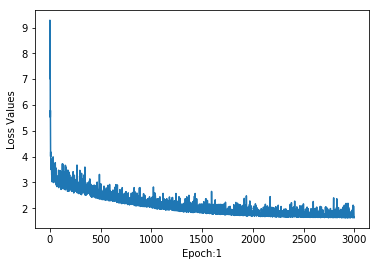

The top 1 Accuracy for lamda=0.2 and t=1 is 0.974


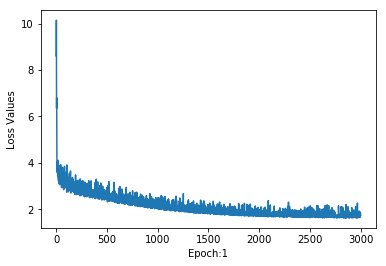

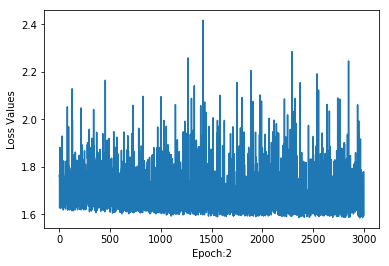

The top 1 Accuracy for lamda=0.2 and t=2 is 0.972833333333


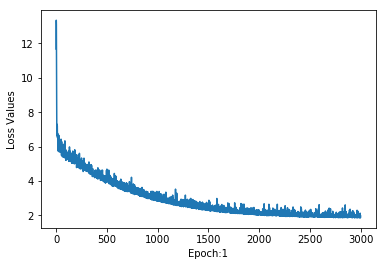

The top 1 Accuracy for lamda=0.4 and t=1 is 0.971333333333


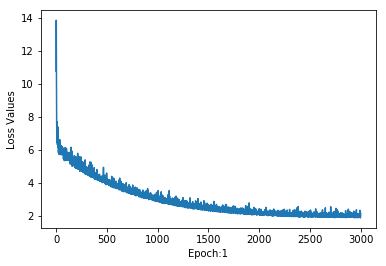

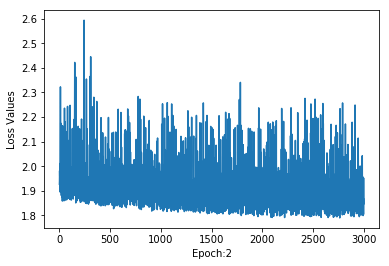

The top 1 Accuracy for lamda=0.4 and t=2 is 0.972583333333


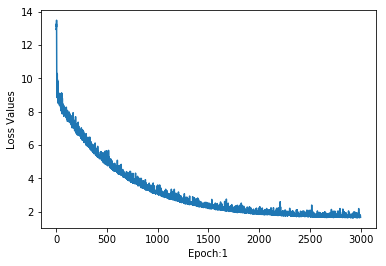

The top 1 Accuracy for lamda=0.6 and t=1 is 0.971083333333


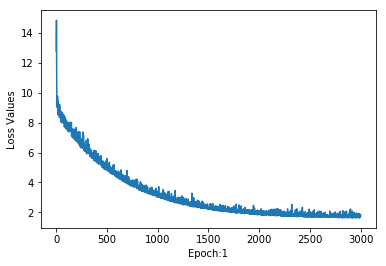

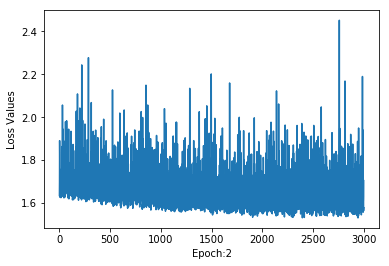

The top 1 Accuracy for lamda=0.6 and t=2 is 0.969833333333


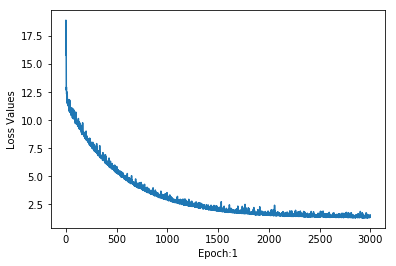

The top 1 Accuracy for lamda=0.8 and t=1 is 0.9665


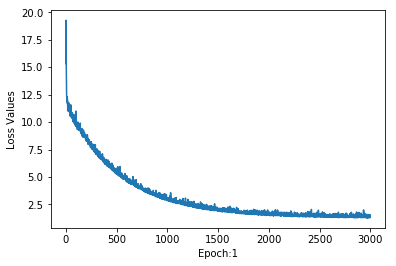

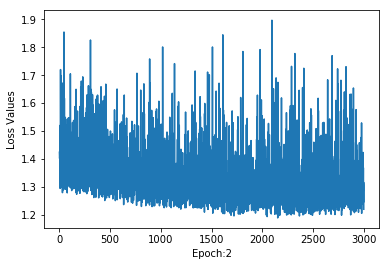

The top 1 Accuracy for lamda=0.8 and t=2 is 0.96825


In [817]:
# Validation Performance
lamda_and_t = [[0.2,1],[0.2,2], [0.4,1],[0.4,2],[0.6,1],[0.6,2],[0.8,1],[0.8,2]] #lamda followed by t, combinations
top_1_accuracy = []

for lamda_t_combinations in lamda_and_t:
    obj = Linearlayer(training_data.shape[1],10, lamda_t_combinations[0], 0.001, 350)
    mydic ={}
    mydic['validation_data'] = validation_data
    mydic['validation_labels'] = validation_labels
    mydic['layer_obj'] = obj
    accuracy = trainMLP(lamda_t_combinations[1], mydic)
    top_1_accuracy.append(accuracy)
    print "The top 1 Accuracy for lamda="+ str(lamda_t_combinations[0])+ " and t="+ str(lamda_t_combinations[1])+" is "+ str(accuracy)

The optimal values of lamda is: 0.2
The optimal values of iteration t is: 1


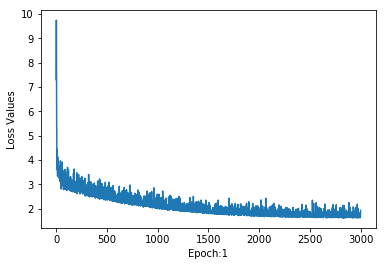

The Accuracy on MNIST test set is 0.9662

The class 0 has accuarcy : 0.982653061224
The class 1 has accuarcy : 0.989427312775
The class 2 has accuarcy : 0.964147286822
The class 3 has accuarcy : 0.967326732673
The class 4 has accuarcy : 0.960285132383
The class 5 has accuarcy : 0.965246636771
The class 6 has accuarcy : 0.969728601253
The class 7 has accuarcy : 0.958171206226
The class 8 has accuarcy : 0.951745379877
The class 9 has accuarcy : 0.950445986125

The best performing class is : class 1
The worst performing class is : class 9


In [825]:
print "The optimal values of lamda is: " + str(lamda_and_t[np.argmax(top_1_accuracy)][0])
print "The optimal values of iteration t is: " + str(lamda_and_t[np.argmax(top_1_accuracy)][1])

# Train on whole dataset with these values,(from scratch)
obj = Linearlayer(training_data.shape[1],10, lamda_and_t[np.argmax(top_1_accuracy)][0], 0.001, 350)
minibatch = get_minibatch_function(train_img, train_label.reshape(len(train_label), 1))
train(obj, lamda_and_t[np.argmax(top_1_accuracy)][1])

# report final performance on mnist test set.
top_1 = data_accuracy(test_img,test_label.reshape(len(test_label), 1),obj) 
print "The Accuracy on MNIST test set is "+ str(top_1)

# Best Class and worst class performance.
scores = obj.forward(test_img)
test_label = test_label.reshape(len(test_label), 1)
predicted =  np.argmax(scores, axis=1).reshape(-1,1)
print "\nThe class 0 has accuarcy : " + str(class_accuracy(0, predicted, test_label))
print "The class 1 has accuarcy : " + str(class_accuracy(1, predicted, test_label))
print "The class 2 has accuarcy : " + str(class_accuracy(2, predicted, test_label))
print "The class 3 has accuarcy : " + str(class_accuracy(3, predicted, test_label))
print "The class 4 has accuarcy : " + str(class_accuracy(4, predicted, test_label))
print "The class 5 has accuarcy : " + str(class_accuracy(5, predicted, test_label))
print "The class 6 has accuarcy : " + str(class_accuracy(6, predicted, test_label))
print "The class 7 has accuarcy : " + str(class_accuracy(7, predicted, test_label))
print "The class 8 has accuarcy : " + str(class_accuracy(8, predicted, test_label))
print "The class 9 has accuarcy : " + str(class_accuracy(9, predicted, test_label))

print "\nThe best performing class is : class "+ str(1)
print "The worst performing class is : class "+ str(9)

# After the lecture on Jan 31st.

# Implementing Convolution Module on Numpy.

* This topic will require you to implement the Convolution operation using Numpy.
* You will implement two methods of doing it, an intuitive and an optimised way.
* Additional operations like dropout, batch norms. 
* We will use the created Module for interesting task like Blurring, Bilateral Filtering.
* Finally, we create the Backprop for this.
* Train a Conv model for the same MNIST dataset. (can be a script based training, instead of having it in jupyter notebook.)
